In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss, hinge_loss, log_loss, mean_squared_error
from sklearn.utils import shuffle

In [20]:
save_folder = 'fig/mnist_all/'
!mkdir -p $save_folder

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [3]:
# number of dimensions of the dataset
d = 784
total_n_train = 60000

#load mnist datasets
MNIST_train = pd.read_csv('data/mnist_train.csv', sep=',')
MNIST_test = pd.read_csv('data/mnist_test.csv', sep=',')

#function that gives 
def mnist_train_sample(n, MNIST_train, do_shuffle=False):
    if do_shuffle:
        MNIST_train = shuffle(MNIST_train)
    X_tr = MNIST_train.iloc[:n, 1:]
    y_tr = MNIST_train.iloc[:n, 0]
    return X_tr, y_tr

X_test, y_test = MNIST_test.iloc[:, 1:], MNIST_test.iloc[:, 0]

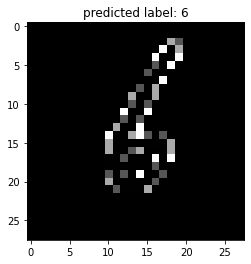

In [275]:
this_X_train, this_y_train = mnist_train_sample(100, MNIST_train, True)
i = 0
two_d = (np.reshape(this_X_train.iloc[i, :].values, (28, 28)) * 255).astype(np.uint8)
plt.title('predicted label: {0}'. format(this_y_train.iloc[i]))
plt.imshow(two_d, interpolation='nearest', cmap='gray')
plt.show()

In [39]:
#fit a standard scaler
scaler = StandardScaler()
scaler.fit(MNIST_train.iloc[:, 1:])

StandardScaler()

In [46]:
models = {}
model_pars = {'C': 0.001, 
              'gamma': 10,
              'kernel': 'poly',
              'probability': True}

n_range = [200, 500, 700, 750, 765, 784, 800, 850, 1000, 1500]

trials = 5

train_loss = {'zero_one': np.zeros(shape=(len(n_range), trials)),
              'hinge': np.zeros(shape=(len(n_range), trials)),
              'log': np.zeros(shape=(len(n_range), trials)),
              'mse': np.zeros(shape=(len(n_range), trials))}
test_loss = {'zero_one': np.zeros(shape=(len(n_range), trials)),
              'hinge': np.zeros(shape=(len(n_range), trials)),
              'log': np.zeros(shape=(len(n_range), trials)),
              'mse': np.zeros(shape=(len(n_range), trials))}

for i, n in enumerate(n_range):
    for trial in range(trials):
        X_tr, y_tr = mnist_train_sample(n, MNIST_train, do_shuffle=False)
        svm_model = SVC(**model_pars)

        # scale
#         scaler = StandardScaler()
#         scaler.fit(X_tr)
        transformed_X_tr = scaler.transform(X_tr)
        transformed_X_test = scaler.transform(X_test)

        # fit svm model
        svm_model.fit(transformed_X_tr, y_tr)
        models[n] = svm_model

        # compute train loss
        y_tr_pred = models[n].predict(transformed_X_tr)
        y_tr_pred_proba = models[n].predict_proba(transformed_X_tr)
        train_loss['zero_one'][i, trial] = zero_one_loss(y_tr, y_tr_pred)
        train_loss['hinge'][i, trial] = hinge_loss(y_tr, y_tr_pred_proba)
        train_loss['log'][i, trial] = log_loss(y_tr, y_tr_pred_proba)
        train_loss['mse'][i, trial] = mean_squared_error(y_tr, y_tr_pred)

        # compute test loss
        y_test_pred = models[n].predict(transformed_X_test)
        y_test_pred_proba = models[n].predict_proba(transformed_X_test)
        test_loss['zero_one'][i, trial] = zero_one_loss(y_test, y_test_pred)
        test_loss['hinge'][i, trial] = hinge_loss(y_test, y_test_pred_proba)
        test_loss['log'][i, trial] = log_loss(y_test, y_test_pred_proba)
        test_loss['mse'][i, trial] = mean_squared_error(y_test, y_test_pred)        

Text(0, 0.5, 'MSE Loss')

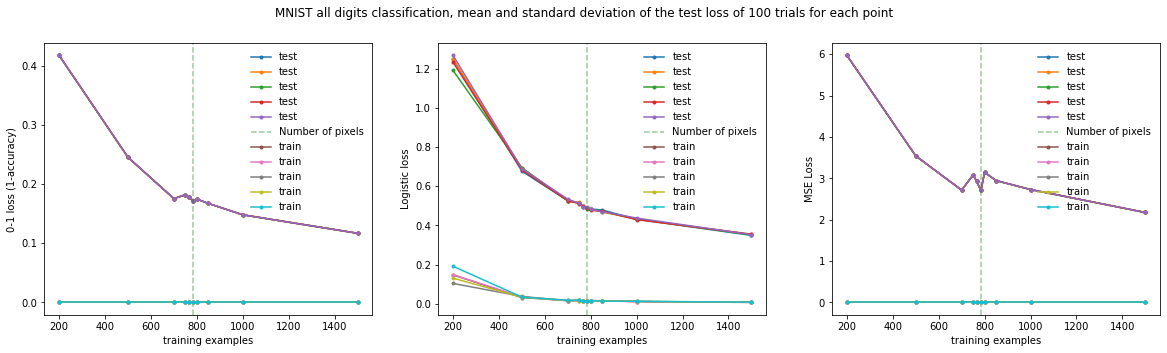

In [47]:
def plot_loss(xs, ys, label, style, vertical_line=True):
    if style == 'quantile':
        qs = np.quantile(ys, [0.16, 0.5, 0.84], axis=1)
        plt.plot(xs, qs[1], label=label)
        plt.fill_between(xs, qs[0], qs[2], alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
    elif style == 'std':
        means = ys.mean(axis=1)
        stds = ys.std(axis=1)
        plt.plot(xs, means, label=label)
        plt.fill_between(xs, means-stds, means+stds, alpha=0.25, color=plt.gca().lines[-1].get_color(), interpolate=True)
    elif style == 'points':
        plt.scatter(np.repeat(xs, trials), ys.flatten(), label=label)
    elif style == 'violin':
        plt.violinplot(ys.T, positions=xs, widths=20, showmeans=True)
    elif style == 'line':
        plt.plot(xs, ys, '.-', label=label)
    
    plt.xlabel("training examples")
    if vertical_line:
        plt.axvline(d, color='green', label='Number of pixels', ls='--', alpha=0.4)
    plt.legend(frameon=False)
#     plt.yscale('log')
    

plt.figure(figsize=[20, 5])
plt.suptitle('MNIST all digits classification, mean and standard deviation of the test loss of 100 trials for each point')
style = 'line'
plt.subplot(131)
plot_loss(n_range, test_loss['zero_one'], 'test', style=style)
plot_loss(n_range, train_loss['zero_one'], 'train', style=style, vertical_line=False)
plt.ylabel("0-1 loss (1-accuracy)")

plt.subplot(132)
plot_loss(n_range, test_loss['log'], 'test', style=style)
plot_loss(n_range, train_loss['log'], 'train', style=style, vertical_line=False)
plt.ylabel("Logistic loss")

plt.subplot(133)
plot_loss(n_range, test_loss['mse'], 'test', style=style)
plot_loss(n_range, train_loss['mse'], 'train', style=style, vertical_line=False)
plt.ylabel("MSE Loss")

# plt.savefig(f'{save_folder}test_and_train_loss_no_average.pdf', bbox_inches='tight')
# plt.savefig(f'{save_folder}test_loss.pdf', bbox_inches='tight')

In [52]:
models[784].support_vectors_.shape

(626, 784)